<!--NOTEBOOK_HEADER-->
*This notebook contains course material from [CBE40455](https://jckantor.github.io/CBE40455) by
Jeffrey Kantor (jeff at nd.edu); the content is available [on Github](https://github.com/jckantor/CBE40455.git).
The text is released under the [CC-BY-NC-ND-4.0 license](https://creativecommons.org/licenses/by-nc-nd/4.0/legalcode),
and code is released under the [MIT license](https://opensource.org/licenses/MIT).*

<!--NAVIGATION-->
< [Scheduling](http://nbviewer.jupyter.org/github/jckantor/CBE40455/blob/master/notebooks/04.00-Scheduling.ipynb) | [Contents](toc.ipynb) | [Machine Bottleneck](http://nbviewer.jupyter.org/github/jckantor/CBE40455/blob/master/notebooks/04.02-Machine-Bottleneck.ipynb) ><p><a href="https://colab.research.google.com/github/jckantor/CBE40455/blob/master/notebooks/04.01-Critical-Path-Method.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://raw.githubusercontent.com/jckantor/CBE40455/master/notebooks/04.01-Critical-Path-Method.ipynb"><img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>

# Critical Path Method

This notebook demonstrates the Critical Path Method using GLPK/MathProg.

## Background

The Critical Path Method is a technique for calculating the shortest time span needed to complete a series of tasks. The tasks are represented by nodes, each labelled with the duration. The precedence order of the task is given by a set of arcs.

Here we demonstrate the representation and calculation of the critical path. Decision variables are introduced for

* Earliest Start
* Earliest Finish
* Latest Start
* Latest Finish
* Slack = Earliest Finish - Earliest Start = Latest Finish - Earliest Finish

Tasks on the Critical Path have zero slack.

## MathProg Model

In [1]:
%%writefile ProjectCPM.mod

# Example: ProjectCPM.mod

set TASKS;
set ARCS within {TASKS cross TASKS};

/* Parameters are the durations for each task */
param dur{TASKS} >= 0;
param desc{TASKS} symbolic;

/* Decision Variables associated with each task*/
var Tes{TASKS} >= 0;     # Earliest Start
var Tef{TASKS} >= 0;     # Earliest Finish
var Tls{TASKS} >= 0;     # Latest Start
var Tlf{TASKS} >= 0;     # Latest Finish
var Tsl{TASKS} >= 0;     # Slacks

/* Global finish time */
var Tf >= 0;

/* Minimize the global finish time and, secondarily, maximize slacks */
minimize ProjectFinish : card(TASKS)*Tf - sum {j in TASKS} Tsl[j];

/* Finish is the least upper bound on the finish time for all tasks */
s.t. Efnsh {j in TASKS} : Tef[j] <= Tf;
s.t. Lfnsh {j in TASKS} : Tlf[j] <= Tf;

/* Relationship between start and finish times for each task */
s.t. Estrt {j in TASKS} : Tef[j] = Tes[j] + dur[j];
s.t. Lstrt {j in TASKS} : Tlf[j] = Tls[j] + dur[j];

/* Slacks */
s.t. Slack {j in TASKS} : Tsl[j] = Tls[j] - Tes[j];

/* Task ordering */
s.t. Eordr {(i,j) in ARCS} : Tef[i] <= Tes[j];
s.t. Lordr {(j,k) in ARCS} : Tlf[j] <= Tls[k];

/* Compute Solution  */
solve;

/* Print Report */
printf 'PROJECT LENGTH = %8g\n',Tf;

/* Critical Tasks are those with zero slack */

/* Rank-order tasks on the critical path by earliest start time */
param r{j in TASKS : Tsl[j] = 0} := sum{k in TASKS : Tsl[k] = 0}
   if (Tes[k] <= Tes[j]) then 1;

printf '\nCRITICAL PATH\n';
printf '  TASK  DUR    Start   Finish  Description\n';
printf {k in 1..card(TASKS), j in TASKS : Tsl[j]=0 && k==r[j]}
   '%6s %4g %8g %8g  %-25s\n', j, dur[j], Tes[j], Tef[j], desc[j];

/* Noncritical Tasks have positive slack */

/* Rank-order tasks not on the critical path by earliest start time */
param s{j in TASKS : Tsl[j] > 0} := sum{k in TASKS : Tsl[k] = 0}
   if (Tes[k] <= Tes[j]) then 1;

printf '\nNON-CRITICAL TASKS\n';
printf '            Earliest Earliest   Latest   Latest \n';
printf '  TASK  DUR    Start   Finish    Start   Finish    Slack  Description\n';
printf {k in 1..card(TASKS), j in TASKS : Tsl[j] > 0 && k==s[j]}
   '%6s %4g %8g %8g %8g %8g %8g  %-25s\n', 
   j,dur[j],Tes[j],Tef[j],Tls[j],Tlf[j],Tsl[j],desc[j];
printf '\n';

end;


Overwriting ProjectCPM.mod


## Example: Stadium Construction

Stadium Construction, [Example 7.1.1](http://www.maximalsoftware.com/modellib/modXpressMP.html) from [Christelle Gueret, Christian Prins, Marc Sevaux, "Applications of Optimization with Xpress-MP," Chapter 7, Dash Optimization, 2000](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.69.9634&rep=rep1&type=pdf).

In [2]:
%%script glpsol -m ProjectCPM.mod -d /dev/stdin -y ProjectCPM.txt --out output

param : TASKS : dur desc :=
   T01   2.0  'Installing the contruction site'
   T02  16.0  'Terracing'
   T03   9.0  'Constructing the foundations'
   T04   8.0  'Access roads and other networks'
   T05  10.0  'Erecting the basement'
   T06   6.0  'Main floor'
   T07   2.0  'Dividing up the changing rooms'
   T08   2.0  'Electrifying the terraces'
   T09   9.0  'Constructing the roof'
   T10   5.0  'Lighting the stadium'
   T11   3.0  'Installing the terraces'
   T12   2.0  'Sealing the roof'
   T13   1.0  'Finishing the changing rooms'
   T14   7.0  'Constructing the ticket office'
   T15   4.0  'Secondary access roads'
   T16   3.0  'Means of signaling'
   T17   9.0  'Lawn and sports accessories'
   T18   1.0  'Handing over the building' ;

set ARCS := 
   T01  T02
   T02  T03
   T02  T04
   T02  T14
   T03  T05
   T04  T07
   T04  T10
   T04  T09
   T04  T06
   T04  T15
   T05  T06
   T06  T09
   T06  T11
   T06  T08
   T07  T13
   T08  T16
   T09  T12
   T11  T16
   T12  T17
   T14  T16
   T14  T15
   T17  T18 ;

end;


In [3]:
f = open('ProjectCPM.txt')
print f.read()
f.close()

PROJECT LENGTH =       64

CRITICAL PATH
  TASK  DUR    Start   Finish  Description
   T01    2        0        2  Installing the contruction site
   T02   16        2       18  Terracing                
   T03    9       18       27  Constructing the foundations
   T05   10       27       37  Erecting the basement    
   T06    6       37       43  Main floor               
   T09    9       43       52  Constructing the roof    
   T12    2       52       54  Sealing the roof         
   T17    9       54       63  Lawn and sports accessories
   T18    1       63       64  Handing over the building

NON-CRITICAL TASKS
            Earliest Earliest   Latest   Latest 
  TASK  DUR    Start   Finish    Start   Finish    Slack  Description
   T04    8       18       26       29       37       11  Access roads and other networks
   T07    2       26       28       61       63       35  Dividing up the changing rooms
   T10    5       26       31       59       64       33  Lighting the sta

## Visualization

/Users/jeff/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/Users/jeff/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


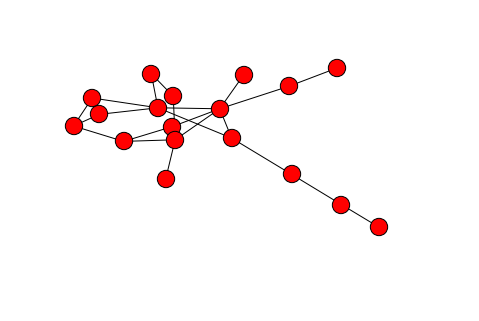

In [5]:
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

G=nx.Graph()
G.add_nodes_from(['T01','T02','T03','T04','T05','T06','T07','T08',\
    'T09','T10','T11','T12','T13','T14','T15','T16','T18'])

G.add_edge('T01','T02')
G.add_edge('T02','T03')
G.add_edge('T02','T04')
G.add_edge('T02','T14')
G.add_edge('T03','T05')
G.add_edge('T04','T07')
G.add_edge('T04','T10')
G.add_edge('T04','T09')
G.add_edge('T04','T06')
G.add_edge('T04','T15')
G.add_edge('T05','T06')
G.add_edge('T06','T09')
G.add_edge('T06','T11')
G.add_edge('T06','T08')
G.add_edge('T07','T13')
G.add_edge('T08','T16')
G.add_edge('T09','T12')
G.add_edge('T11','T16')
G.add_edge('T12','T17')
G.add_edge('T14','T16')
G.add_edge('T14','T15')
G.add_edge('T17','T18') ;

nx.draw(G)
plt.show()

<!--NAVIGATION-->
< [Scheduling](http://nbviewer.jupyter.org/github/jckantor/CBE40455/blob/master/notebooks/04.00-Scheduling.ipynb) | [Contents](toc.ipynb) | [Machine Bottleneck](http://nbviewer.jupyter.org/github/jckantor/CBE40455/blob/master/notebooks/04.02-Machine-Bottleneck.ipynb) ><p><a href="https://colab.research.google.com/github/jckantor/CBE40455/blob/master/notebooks/04.01-Critical-Path-Method.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://raw.githubusercontent.com/jckantor/CBE40455/master/notebooks/04.01-Critical-Path-Method.ipynb"><img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>